# More Data Wrangling

Use **Code** cells to write and run any code you need to answer the question and **Markdown** cells to write out answers in words. After you are finished with the assignment, remember to download it as an **HTML file** and submit it in **ELMS**.

In [1]:
from requests import get
from datetime import datetime
import yaml
import numpy as np 
import pandas as pd 

## Working with Data

Many times, when we are working with Data Frames and tabular data, each row represents a person or entity. That is, the **unit of observation** is a person and the variables all describe that person. We've also looked at data where the unit of observation was a US state. However, this is not always the case. You need to be careful and think through exactly what each row represents, and transform your data if it needs to be in another form. Let's take the merged anxiety and Census data as an example. This is available in the `anxiety_census_data.csv` file, and contains the proportion of people who reported feeling anxious all or most of the last 7 days within each state for a series of days from May 1, 2022 to June 25, 2022. 

In [2]:
anxiety_census = pd.read_csv('anxiety_census_data.csv')
anxiety_census.head()

,num_households,mean_income,percent_employed,percent_bachelors,percent_graduate,state,Abbreviation,Region,time_value,value,stderr
0,2016448.0,100785.0,58.6,28.8,11.3,Alabama,al,South,2022-05-01,18.068456,1.422070
1,2016448.0,100785.0,58.6,28.8,11.3,Alabama,al,South,2022-05-02,16.767083,1.393164
2,2016448.0,100785.0,58.6,28.8,11.3,Alabama,al,South,2022-05-03,17.299152,1.426524
3,2016448.0,100785.0,58.6,28.8,11.3,Alabama,al,South,2022-05-04,19.152474,1.502354
4,2016448.0,100785.0,58.6,28.8,11.3,Alabama,al,South,2022-05-05,17.460357,1.453635


In this dataset, the unit of observation is a **state-date** combination. A unique row is represented by a state on a particular date. 

<font color ='red'>**Question 1: Create a subset of the `anxiety_census` so that it only contains Maryland and Virginia. Include only the variables `state`, `time_value`, and `value`. Call this new DataFrame `md_va`.**</font>

## Reshaping Data

Suppose we want to graph the data for these two states together, so that we can see how the trends differ between them. In order to use the `plot.line` method and use both, we actually need them in two different columns. That is, we need one variable to be the value for Maryland on a given day and one variable to be the value for Virginia on that day. 

In other words, right now, each row represents a **state-date pair**. For example, the first row is Maryland on May 1, 2022, the second row is Maryland on May 2, 2022, and so on eventually going to Virginia on May 1, 2022, then Virginia on May 2, 2022, and so on. Instead, we want data that has each row represent a **date**, with separate columns for the values of Maryland and Virigina on that day. 

In [4]:
wide_data = md_va.pivot(index = 'time_value', columns = 'state', values = 'value')
wide_data.head()


state,Maryland,Virginia
time_value,,
2022-05-01,18.445571,13.477643
2022-05-02,17.348098,13.749526
2022-05-03,18.411396,14.036378
2022-05-04,16.618852,13.561209
2022-05-05,15.175465,12.893021


Note that the dates have been turned into the indices. If we wanted to include them as a variable instead, we could have used `reset_index` to reset the index back to incrementing up from 0, but we'll leave it as it is for now because it is useful for graphing purposes.

In [5]:
# If we had wanted to reset the index.
wide_data.reset_index().head()

state,time_value,Maryland,Virginia
0,2022-05-01,18.445571,13.477643
1,2022-05-02,17.348098,13.749526
2,2022-05-03,18.411396,14.036378
3,2022-05-04,16.618852,13.561209
4,2022-05-05,15.175465,12.893021


Now that we've gotten our data into this format, we can create our line plot by indicating color. We use a dictionary to specify which column corresponds to which color.

<Axes: xlabel='time_value'>

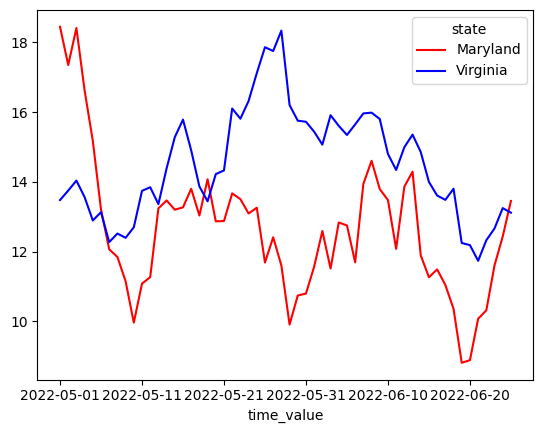

In [6]:
wide_data.plot.line(color = {'Maryland':'red', 'Virginia':'blue'})

<font color ='red'>**Question 2: Create a line graph comparing the trends for Maryland, Virginia, and New York.**</font>

## Going from Wide to Long

We can also go the opposite way for data that might require long format.

In [71]:
wide_data.melt(ignore_index = False).reset_index()

,time_value,state,value
0,2022-05-01,Maryland,18.445571
1,2022-05-02,Maryland,17.348098
2,2022-05-03,Maryland,18.411396
3,2022-05-04,Maryland,16.618852
4,2022-05-05,Maryland,15.175465
...,...,...,...
107,2022-06-21,Virginia,11.736808
108,2022-06-22,Virginia,12.326627
109,2022-06-23,Virginia,12.665318
110,2022-06-24,Virginia,13.247298


## More Merging Practice

Let's try doing another merge. Let's say we want to take a look at anxiety trends for the month of May 2022, and try to see if there's any current events that may correlate with any changes as the month goes on. In order to look at this, we might want to combine data from the NYT Archives with the data on anxiety trends.

Recall that we can pull all articles from the NYT Archives API for a given month. So, we'll start by getting all articles from May 2022.

In [9]:
# reading in our keys
with open('../../keys.yml', 'r') as file:
    keys = yaml.safe_load(file)
nyt_key = keys['nyt_api_key']

In [10]:


base_url = "https://api.nytimes.com/svc/archive/v1/2022/5.json"
r = get(base_url, params= {'api-key':nyt_key}) 
archive_2022_05 = r.json()['response']['docs']


In [14]:
archive_2022_05[0].keys()

dict_keys(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'source', 'multimedia', 'headline', 'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name', 'byline', 'type_of_material', '_id', 'word_count', 'uri'])

Next, we'll get the data that we want as a DataFrame. We want to retain some basic information like abstract and type of material and word count, as well as the publication date so that we can match on the anxiety data. 

In [ ]:
variables = ['abstract', 'web_url','pub_date', 'type_of_material','word_count']
nyt_dict = {var:[article[var] for article in archive_2022_05] for var in variables}
nyt_df = pd.DataFrame(nyt_dict)
nyt_df.head()

Note that the `pub_date` variable is not the same format as the one in the anxiety data. Notably, it has a lot more specific time associated with that article. Let's add a new variable called `date` that contains just the date information in the same format as is in the anxiety dataset (namely, YYYY-MM-DD).

<font color ='red'>**Question 3: Add a column to `nyt_df` called `date` that contains the date in the same format as it is in the anxiety dataset. That is, it should have be in YYYY-MM-DD format.**</font>

*Hint:* This is just the first 10 characters of the string

<font color ='red'>**Question 4: What does each row in the `nyt_df` DataFrame represent?**</font>

Answer:

Next, let's get the relevant data for just New York and in the month of May. 

<font color ='red'>**Question 5: Create a DataFrame called `ny_anxiety_census` that contains just the rows of `anxiety_census` that are for New York state.**</font>

Now that we've gotten a dataset with only values from New York, we'll further subset the data to only include the dates in May. 

In [ ]:
ny_may = ny_anxiety_census[ny_anxiety_census.time_value <= '2022-05-31']
ny_may.head()

> Note: This works because the format of the date in the string organizes it alphabetically already. If we wanted to be more careful or wanted to make sure that it would work for all different types of date formats, we would actually convert this into a date object first because doing a comparison. You can try using code such as `datetime.strptime('2022-05-30', '%Y-%m-%d').date()` to get the date. This converts the string into a datetime format, then extracts the date.

In [ ]:
ny_may.shape

<font color ='red'>**Question 6: What does each row in the `ny_may` DataFrame represent?**</font>

Answer: 

The `nyt_df` DataFrame and the `ny_may` DataFrame have different **units of observation**. So, if we want to combine them together, we have to be careful about how to do it. For example, if we want to make sure we only have one row per day (since we want to look at the change over the days), then we might want to first make sure that both DataFrames have the day as the unit of observation. To do this, we'll aggregate using `groupby` to get some summary measures that we'll track over the course of the month.

<font color ='red'>**Question 7: Using `apply`, find the total number of News articles there were in each day of May.**</font>

We can create a custom function to do more than computation with a group at once as well.

In [ ]:
def nyt_summary(x):
    return pd.Series([sum(x['type_of_material'] == 'News'), x.count()[0]])

nyt_by_day = nyt_df.groupby('date').apply(nyt_summary).reset_index()
nyt_by_day.columns = ['time_value', 'news', 'total']

Note that we use `reset_index()` to make it so that the date is a column in the DataFrame. We also change the column names, making it so that the column name for the date is the same name as it is in the `ny_may` DataFrame. This is because if we have the same column name for what we want to merge on, then we don't need to specify `left_on` and `right_on`. Using `merge` will automatically merge on the common column name.

In [ ]:
ny_merged = nyt_by_day.merge(ny_may)
ny_merged.head()


<font color ='red'>**Question 8: In the month of May, did the number of News articles each day in the New York Times have any relationship with the reported anxiety on that day? Use a scatterplot to show the relationship.**</font>

*Note:* Remember, the method to create a scatterplot from a DataFrame is `.scatter.plot()` with two arguments: the x variable and y variable for the scatterplot.

> This isn't exactly a particularly interesting thing to look at because we wouldn't necessarily expect there to be a relationship on that day. Remember, the question asked whether the respondent had felt anxious in the past 7 days. We also aren't looking at the topics of the News articles. To do more sophisticated analyses, we would want to do some more cleaning and try thinking about extracting more information from things like the abstract.

## Overview

Steps to preparing data for analysis (particularly from APIs).

1. Obtain data using API or reading in from a CSV file. Helpful functions: `pd.read_csv`, `get`. 
2. Identify the type of data that you have. Is it a dictionary? A list? What does each item within the list or dictionary represent?
3. Develop a plan to extract the data that you want. Try getting just one, then think about how you might generalize it to be able to use list comprehension or dictionary comprehension. 
4. Create a DataFrame and do some cleanup of the data. Make sure the column names are meaningful and the types of variables are what you need them to be (e.g., numeric if they are numeric variables). Make sure you know what the unit of observation is.
5. Identify any additional data wrangling steps you might need to take. Do you need to join datasets together? Do you need to group and aggregate data?

# Extra code

Here's an example of reshaping the FiveThirtyEight's state level presidential election data.

The original data is in long format, with one row per candidate per state per cycle. We want to use this to just calculate Trump and Biden's share of the two party vote in 2020. 

In [20]:
data = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/election-results/refs/heads/main/election_results_presidential.csv')

After reading in the data, our first step is to filter it to remove the following:

- rows other than the 2020 election
- any data on primary races
- data for candidates other than Trump or Biden
- any cases where `state_abbrev` is null (these are results for the entire country)
- Maine and Nebraska's weird system of allocating electoral votes based on congressional district.  


In [30]:
data_2020 = data[(data['cycle'] == 2020) &  # 2020 cycle only
                 (data['stage'] == 'general') &  # general election only
                 (data['candidate_name'].isin(["Donald Trump", "Joe Biden"])) &
                 (data['state_abbrev'].notnull()) & # only state level results
                 (data['state_abbrev'].str.contains('[0-9]')==False) # removing special Maine and Nebraska district-level results
                        ]

Next, we'll remove some extraneous columns:

In [31]:
pres_vote = data_2020.loc[:, ['state','state_abbrev', 'candidate_name', 'votes']]

In [32]:
pres_vote.head()

,state,state_abbrev,candidate_name,votes
1780,Indiana,IN,Joe Biden,1242416.0
1783,Indiana,IN,Donald Trump,1729519.0
1803,New York,NY,Joe Biden,4844975.0
1804,New York,NY,Joe Biden,386010.0
1809,New York,NY,Donald Trump,295657.0


Next, we'll want to get the total votes for each state. We can do this using groupby and `sum`:

In [38]:
pres_vote_total = pres_vote.groupby(['candidate_name', 'state', 'state_abbrev']).sum()


pres_vote_total.head()

votes
candidate_name state      state_abbrev           
Donald Trump   Alabama    AL            1441170.0
               Alaska     AK             189951.0
               Arizona    AZ            1661686.0
               Arkansas   AR             760647.0
               California CA            6006429.0

Next, we'll pivot the results from long to wide:

In [40]:
presvote_wide =pres_vote_total.reset_index().pivot(index = 'state', columns = 'candidate_name', values = 'votes')
presvote_wide.head()

candidate_name,Donald Trump,Joe Biden
state,,
Alabama,1441170.0,849624.0
Alaska,189951.0,153778.0
Arizona,1661686.0,1672143.0
Arkansas,760647.0,423932.0
California,6006429.0,11110250.0


Finally, we'll calculate the total number of votes cast in each state by `sum`-ing along the row axis, then we'll create a variable called `trumpshare` that contains Donald Trumps proportion of the two party vote in each state:

In [48]:
presvote_wide.loc[:, 'total'] = presvote_wide[["Donald Trump", "Joe Biden"]].sum(axis=1)
presvote_wide.loc[:, 'trumpshare'] = presvote_wide['Donald Trump'].div(presvote_wide['total'])

In [52]:
presvote_wide.head()

candidate_name,Donald Trump,Joe Biden,total,trumpshare
state,,,,
Alabama,1441170.0,849624.0,2290794.0,0.629114
Alaska,189951.0,153778.0,343729.0,0.552618
Arizona,1661686.0,1672143.0,3333829.0,0.498432
Arkansas,760647.0,423932.0,1184579.0,0.642124
California,6006429.0,11110250.0,17116679.0,0.350911
